In [1]:
# List all available Sentinel-2 Level-2A bands
from slc.data import list_bands

bands = list_bands()

print("All available Level-2A Bands:", bands)

All available Level-2A Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [2]:
# List all available indices offered by eemont
from slc.data import list_indices

indices = list_indices()

print("All applicable indices offered by eemont:", indices)

All applicable indices offered by eemont: ['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CIG', 'CIRE', 'CSI', 'CVI', 'DBSI', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'EMBI', 'EVI', 'EVI2', 'ExG', 'ExGR', 'ExR', 'FCVI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MuWIR', 'NBAI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRplus', 'NBSIMS', 'ND705', 'NDBI', 'NDCI', 'NDDI', 'NDGI', 'NDGlaI', 'NDII', 'NDMI', 'NDPI', 'NDPonI', 'NDREI', 'NDSI', 'NDSII', 'NDSInw', 'NDSWIR', 'NDSaII', 'NDSoI', 'NDTI', 

In [3]:
# Create a composite from a Sentinel image with all available bands and indices
from datetime import datetime
from pathlib import Path
from zoneinfo import ZoneInfo

import rasterio
from tqdm.notebook import tqdm

from slc.data import sentinel_composite

tz = ZoneInfo("CET")

# Define the label path as well as the path to write the raster to
target_folder = Path("../data/processed/target/")
data_folder = Path("../data/processed/band_importance/data/")

# Create the 2A composite if it does not exist
data_folder.mkdir(parents=True, exist_ok=True)
for target_path in tqdm(tuple(target_folder.glob("*.tif"))):
    data_path = data_folder / target_path.name
    year = int(target_path.stem.split("_")[-1])

    if not data_path.exists():
        try:
            sentinel_composite(
                target_path_from=target_path,
                data_path_to=data_path,
                time_window=(
                    datetime(year, 1, 1, tzinfo=tz),
                    datetime(year + 1, 1, 1, tzinfo=tz),
                ),
                sentinel_bands=bands,
                indices=indices,
            )
        except KeyboardInterrupt as exc:
            raise KeyboardInterrupt from exc
        except Exception:  # noqa: BLE001
            # Download composite in two steps if it fails
            sentinel_composite(
                target_path_from=target_path,
                data_path_to="tmp.tif",
                time_window=(
                    datetime(year, 1, 1, tzinfo=tz),
                    datetime(year + 1, 1, 1, tzinfo=tz),
                ),
                sentinel_bands=bands,
                indices=indices[: len(indices) // 2],
            )

            sentinel_composite(
                target_path_from=target_path,
                data_path_to="tmp2.tif",
                time_window=(
                    datetime(year, 1, 1, tzinfo=tz),
                    datetime(year + 1, 1, 1, tzinfo=tz),
                ),
                sentinel_bands=[],
                indices=indices[len(indices) // 2 :],
            )

            with rasterio.open("tmp.tif") as src1, rasterio.open("tmp2.tif") as src2:
                profile = src1.profile
                profile.update(count=src1.count + src2.count)
                descriptions = src1.descriptions + src2.descriptions
                with rasterio.open(data_path, "w", **profile) as dst:
                    for i in range(1, src1.count + 1):
                        dst.write(src1.read(i), i)
                    for i in range(1, src2.count + 1):
                        dst.write(src2.read(i), src1.count + i)

                    dst.descriptions = descriptions

            Path("tmp.tif").unlink()
            Path("tmp2.tif").unlink()

            print("Created composite in two steps for", target_path)

  0%|          | 0/51 [00:00<?, ?it/s]

In [4]:
# Compute the scores for each step of the RFE
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate
from tqdm.notebook import tqdm

from slc.data import split_band_name
from slc.features import load_dataset

# Check if the report is already available
band_importance_path = "../reports/band_importance.csv"
if not Path(band_importance_path).exists():
    Path(band_importance_path).parent.mkdir(parents=True, exist_ok=True)

    # Load the dataset
    data, target = load_dataset(data_folder, target_folder)

    # Create the RFE object and rank each pixel
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=1, step=1, verbose=1)
    rfe.fit(data, target)

    # Define the scoring metrics
    scoring = {
        "F1 Score": make_scorer(f1_score),
        "Accuracy": make_scorer(accuracy_score),
        "Kappa": make_scorer(cohen_kappa_score),
    }

    # Get the features in reverse order of elimination
    ranking = rfe.ranking_
    feature_names = rfe.feature_names_in_
    order_index = ranking.argsort()
    ordered_features = feature_names[order_index]

    # Compute the score for each step of the RFE
    score_df = pd.DataFrame(columns=scoring.keys())
    for i in tqdm(range(ordered_features.shape[0])):
        # Fit the model with the current features
        curr_data = data[ordered_features[: i + 1]]
        random_forest = RandomForestClassifier(n_jobs=-1, random_state=42)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_validate(
            random_forest, curr_data, target, cv=cv, scoring=scoring, n_jobs=-1
        )

        # Store the score in the dataframe
        band_label = split_band_name(ordered_features[i])[1]
        score_df.loc[band_label] = [scores[f"test_{key}"].mean() for key in scoring]

    # Save the scores to a CSV file
    score_df.to_csv(band_importance_path, index_label="Band")
    score_df.index.name = "Band"
else:
    # Load the scores from the CSV file
    score_df = pd.read_csv(band_importance_path, index_col=0)

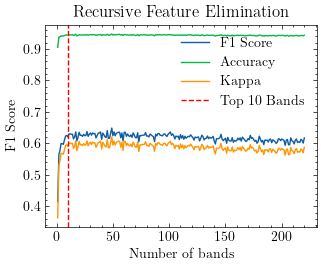

In [5]:
# Plot the RFE scores for n bandsimport matplotlib.pyplot as plt^
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401

# Use science style for plots
plt.style.use("science")

# Plot RFE scores
score_df["Index"] = range(1, score_df.shape[0] + 1)
ax = score_df.plot(x="Index", y="F1 Score", label="F1 Score")
ax = score_df.plot(x="Index", y="Accuracy", ax=ax, label="Accuracy")
ax = score_df.plot(x="Index", y="Kappa", ax=ax, label="Kappa")
ax.axvline(10, color="red", linestyle="--", label="Top 10 Bands")

# Format the plot
ax.set_title("Recursive Feature Elimination")
ax.set_xlabel("Number of bands")
ax.set_ylabel("F1 Score")
ax.legend()

figure_path = f"../reports/figures/band_importance/{ax.get_title()}.svg"
Path(figure_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figure_path, dpi=300, transparent=True)

In [6]:
# List all selected bands and indices
from slc.models import bands_from_importance

sentinel_bands, index_bands = bands_from_importance(band_importance_path, top_n=10)

print("Level-2A bands:", sentinel_bands)
print("Indices:", index_bands)

Level-2A bands: ['B11']
Indices: ['BRBA', 'GDVI', 'IKAW', 'MBWI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'SWI', 'WI2015']
